In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Define Data Loader

In [3]:
# Showing one example
model_type = 'clip'
data_loader = loaders.DataLoader(data_source = "qa", model_type=model_type, logger=logger)
df_table = data_loader.load_dialogue_df()

In [4]:
df_table

,image_id,dialog,caption,dialog_full,file_name,name,supercategory,set_source
0,378466,"[{'answer': 39276, 'gt_index': 74, 'question':...",a person that is laying next to a dog,Q: is this a child or adult\nA: adult\nQ: male...,COCO_train2014_000000378466.jpg,"[dog, person, bed]","[animal, person, furniture]",train2014
1,575029,"[{'answer': 216336, 'gt_index': 93, 'question'...",a black and white photo of a man on a horse by...,"Q: what color is horse\nA: brown, but it's bla...",COCO_train2014_000000575029.jpg,"[horse, car, person, tie, banana]","[animal, vehicle, person, accessory, food]",train2014
2,287140,"[{'answer': 64297, 'gt_index': 21, 'question':...",a couple of people and some motor bikes,Q: how many bikes there\nA: 3\nQ: what color a...,COCO_train2014_000000287140.jpg,"[motorcycle, person]","[vehicle, person]",train2014
3,378461,"[{'answer': 249727, 'gt_index': 20, 'question'...","a kitchen with light colored wood cabinets, a ...",Q: what color is the sink\nA: white\nQ: is the...,COCO_train2014_000000378461.jpg,"[person, oven, sink]","[person, appliance]",train2014
4,332243,"[{'answer': 71412, 'gt_index': 30, 'question':...",a giraffe takes food from a feeding bin high u...,Q: is this a zoo\nA: yes\nQ: how many giraffes...,COCO_train2014_000000332243.jpg,"[cow, zebra, giraffe]",[animal],train2014
...,...,...,...,...,...,...,...,...
122213,229324,"[{'answer': 59111, 'gt_index': 40, 'question':...",an empty kitchen with a center island made out...,Q: is this a large kitchen\nA: yes\nQ: can you...,COCO_val2014_000000229324.jpg,"[microwave, sink]",[appliance],val2014
122214,213795,"[{'answer': 59111, 'gt_index': 51, 'question':...",2 elephants pf different heights walking while...,Q: is this photo in color\nA: yes\nQ: any peop...,COCO_val2014_000000213795.jpg,[elephant],[animal],val2014
122215,464476,"[{'answer': 88516, 'gt_index': 21, 'question':...",a man is seen walking out of a building,Q: how old is the man\nA: i can only see his b...,COCO_val2014_000000464476.jpg,"[tv, train, person]","[electronic, vehicle, person]",val2014
122216,234766,"[{'answer': 59111, 'gt_index': 50, 'question':...",a skateboarder is in the air as he performs a ...,Q: is the image in color\nA: yes\nQ: is it day...,COCO_val2014_000000234766.jpg,"[person, skateboard]","[person, sports]",val2014


# Define OOD Categories below

In [5]:
import gensim.downloader as api
wv_model = api.load("word2vec-google-news-300")

In [6]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
nltk.download('wordnet')


lemmatizer = WordNetLemmatizer()
new_supercategories = ['person', 
                       'animal', 
                       'vehicle', 
                       'city', 
                       'fashion', 
                       'sports', 
                       'tableware', 
                       'food', 
                       'furniture', 
                       'electricity', 
                       'appliance', 
                       'bedroom']
lemmatized_supercategories = [lemmatizer.lemmatize(word) for word in new_supercategories]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WFYIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
cosine_similarity_list = []
for category_a in new_supercategories:
    cosine_sim_current = 0
    for category_b in new_supercategories:
        text_tokens_a = wv_model[category_a]
        text_tokens_b = wv_model[category_b]
        cosine_sim_current += 1 - np.dot(text_tokens_a, text_tokens_b) / (np.linalg.norm(text_tokens_a) * np.linalg.norm(text_tokens_b))
    print(f"Cosine similarity for {category_a} is: {cosine_sim_current - 1}")
    cosine_similarity_list.append(cosine_sim_current - 1)

Cosine similarity for person is: 8.585654471069574
Cosine similarity for animal is: 8.364568384364247
Cosine similarity for vehicle is: 8.176514141261578
Cosine similarity for city is: 8.612666450440884
Cosine similarity for fashion is: 8.381578899919987
Cosine similarity for sports is: 8.841268377378583
Cosine similarity for tableware is: 7.922549072653055
Cosine similarity for food is: 7.767537582665682
Cosine similarity for furniture is: 7.248661812394857
Cosine similarity for electricity is: 8.376395015046
Cosine similarity for appliance is: 8.000125385820866
Cosine similarity for bedroom is: 8.31794491223991


In [8]:
from nltk.corpus import wordnet as wn

wn_list = []
for category_a in lemmatized_supercategories:
    sim_current = 0
    for category_b in lemmatized_supercategories:
        similarity = 1 - wn.synset(f"{category_a}.n.01").path_similarity(wn.synset(f"{category_b}.n.01"))
        #logger.info(f"Similarity between {category_a} and {category_b} is: {similarity}")
        sim_current += similarity
    logger.info(f"Sum similarity for {category_a} is: {sim_current - 1}")
    wn_list.append(sim_current - 1)

2024-07-19 10:38:39,173 - notebook_logger - INFO - Sum similarity for person is: 8.447979797979798
2024-07-19 10:38:39,175 - notebook_logger - INFO - Sum similarity for animal is: 8.6002886002886
2024-07-19 10:38:39,176 - notebook_logger - INFO - Sum similarity for vehicle is: 8.665476190476191
2024-07-19 10:38:39,178 - notebook_logger - INFO - Sum similarity for city is: 9.091579254079255
2024-07-19 10:38:39,179 - notebook_logger - INFO - Sum similarity for fashion is: 8.99489121989122
2024-07-19 10:38:39,181 - notebook_logger - INFO - Sum similarity for sport is: 9.191233766233767
2024-07-19 10:38:39,183 - notebook_logger - INFO - Sum similarity for tableware is: 8.779761904761905
2024-07-19 10:38:39,184 - notebook_logger - INFO - Sum similarity for food is: 8.834848484848486
2024-07-19 10:38:39,186 - notebook_logger - INFO - Sum similarity for furniture is: 8.665476190476191
2024-07-19 10:38:39,188 - notebook_logger - INFO - Sum similarity for electricity is: 9.023462648462647
2024-

In [9]:
final_average = {}
for i in range(len(new_supercategories)):
    #logger.info(f"Category: {new_supercategories[i]} - Cosine Similarity: {cosine_similarity_list[i]} - WordNet Similarity: {wn_list[i]}")
    average = (cosine_similarity_list[i] + wn_list[i]) / 2
    logger.info(f"Category: {new_supercategories[i]} Average: {average}")
    final_average[new_supercategories[i]] = average

df = pd.DataFrame(list(final_average.items()), columns=['Key', 'Value'])
df.sort_values(by='Value', ascending=False, inplace=True)
df

2024-07-19 10:38:39,199 - notebook_logger - INFO - Category: person Average: 8.516817134524686
2024-07-19 10:38:39,199 - notebook_logger - INFO - Category: animal Average: 8.482428492326424
2024-07-19 10:38:39,199 - notebook_logger - INFO - Category: vehicle Average: 8.420995165868884
2024-07-19 10:38:39,200 - notebook_logger - INFO - Category: city Average: 8.85212285226007
2024-07-19 10:38:39,200 - notebook_logger - INFO - Category: fashion Average: 8.688235059905605
2024-07-19 10:38:39,200 - notebook_logger - INFO - Category: sports Average: 9.016251071806174
2024-07-19 10:38:39,202 - notebook_logger - INFO - Category: tableware Average: 8.35115548870748
2024-07-19 10:38:39,202 - notebook_logger - INFO - Category: food Average: 8.301193033757084
2024-07-19 10:38:39,202 - notebook_logger - INFO - Category: furniture Average: 7.957069001435524
2024-07-19 10:38:39,203 - notebook_logger - INFO - Category: electricity Average: 8.699928831754324
2024-07-19 10:38:39,203 - notebook_logger -

,Key,Value
5,sports,9.016251
3,city,8.852123
9,electricity,8.699929
4,fashion,8.688235
11,bedroom,8.605772
0,person,8.516817
1,animal,8.482428
2,vehicle,8.420995
6,tableware,8.351155
10,appliance,8.332801


In [10]:
ood_category = ['animal']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]
df_table['OOD'] = df_table['supercategory'].apply(lambda x: 0 if any(item in x for item in ood_category) else 1)
df_table['OOD'].value_counts()

OOD
1    97213
0    25005
Name: count, dtype: int64

# Load CLIP features for images and dialogues with Model CLIP ViT-B32

In [11]:
if data_loader.data_source == "real":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
    image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
    image_annotation.rename(columns={0:"image_clip"}, inplace=True)
    df_table = df_table.merge(image_annotation, on='img_file', how='left')

elif data_loader.data_source == "qa":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_dialogs_truncate/qa_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    df_table['image_file'] = df_table['image_id'].astype('str') + '.jpg'
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/QA_imgs/qa_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/QA_imgs/all_img_names.json')
    image_annotation = image_annotation.rename(columns={0:"image_file"})
    image_annotation['image_clip'] = list(image_clip)
    df_table = df_table.merge(image_annotation, on='image_file', how='left') 

elif data_loader.data_source == "meld":
    df_dialogue = data_loader.load_dialogue_df()
    df_image = data_loader.load_image_df()
    df_table[f"dialogue_{model_type}"] = list(df_dialogue)
    df_table[f"image_{model_type}"] = list(df_image)
    

In [12]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategory']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [13]:
def image_text_similarity(row):
    a = row[f'dialogue_{model_type}']
    b = row[f'image_{model_type}']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)

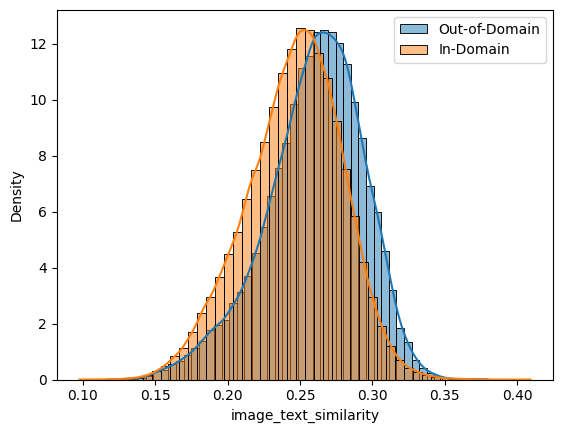

In [14]:
sns.histplot(df_table[df_table['OOD'] == 0]['image_text_similarity'], bins=50, kde=True, label='Out-of-Domain', stat='density')
sns.histplot(df_table[df_table['OOD'] == 1]['image_text_similarity'], bins=50, kde=True, label='In-Domain', stat='density')
plt.legend()

In [ ]:
#print('Image Max:', ev.fpr_evaluation(df_table['OOD'].values, df_table['image_score_max'].values, 0.95))
#print('Image Sum:', ev.fpr_evaluation(df_table['OOD'].values, df_table['image_score'].values, 0.95))
#print('Dialogue Max:', ev.fpr_evaluation(df_table['OOD'].values, df_table['dialogue_score_max'].values, 0.95))
#print('Dialogue Sum:', ev.fpr_evaluation(df_table['OOD'].values, df_table['dialogue_score'].values, 0.95))
#print('Dialogue Segment Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment_max'].values, 0.95))
#print('Dialogue Segment Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment'].values, 0.95))
#print("Overall Max:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity'].values, 0.95))
#print("Overall Sum:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_sum'].values, 0.95))
#print("Overall Transform Max:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_transform'].values, 0.95))
#print("Overall Transform Sum:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_transform_sum'].values, 0.95))

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from models.DNN import model 
import importlib
importlib.reload(model)

image_model_loader = model.model_loader(logger=logger,
                                  input_size=512,
                                  num_epochs=10,
                                  output_size=len(ind_category),
                                  learning_rate=0.001,
                                  proportion = 0.8,
                                  seed = 20)

dialogue_model_loader = model.model_loader(logger=logger,
                                    input_size=512,
                                    num_epochs=10,
                                    output_size=len(ind_category),
                                    learning_rate=0.001,
                                    seed = 20)

(
    df_ind_train, 
    df_test, 
    X_train_image, 
    X_test_image, 
    X_train_dialogue, 
    X_test_dialogue, 
    Y_train, 
    Y_test
) = image_model_loader.create_dataset(data_loader, df_table, add_mismatch = True, mismatch_num = 2000, used_model = model_type)

df_test['image_text_similarity'] = df_test.apply(image_text_similarity, axis=1)

2024-07-19 10:38:48,087 - notebook_logger - INFO - Setting random seed: 20
2024-07-19 10:38:48,092 - notebook_logger - INFO - Setting random seed: 20


In [16]:
df_test[(df_test['OOD'] == 0) & (df_test['supercategories'] != 'anger')][['utterance', 'supercategories', 'image_text_similarity']].head(30)

KeyError: 'supercategories'

In [ ]:
sns.histplot(df_test[df_test['OOD'] == 1]['image_text_similarity'], kde=True, label='In-Domain', bins=50, stat='density')
sns.histplot(df_test[df_test['OOD'] == 0]['image_text_similarity'], kde=True, label='Out-of-Domain', bins=50, stat='density')
plt.legend()

In [ ]:
image_model_loader.train_model(X_train_image, Y_train, X_test_image, Y_test, ood_category = '_'.join(ood_category))

In [ ]:
dialogue_model_loader.train_model(X_train_dialogue, Y_train, X_test_dialogue, Y_test, ood_category = '_'.join(ood_category))

In [ ]:
score_type_list = ["prob", "energy", "logits", "msp"]

for score_type in score_type_list:
    image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    df_test[f'{score_type}_sum_image'] = image_score_sum
    df_test[f'{score_type}_max_image'] = image_score_max
    df_test[f'{score_type}_sum_dialogue'] = dialogue_score_sum
    df_test[f'{score_type}_max_dialogue'] = dialogue_score_max
    df_test[f'{score_type}_max_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_image'] 
    df_test[f'{score_type}_max_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_dialogue']
    df_test[f'{score_type}_sum_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_image']
    df_test[f'{score_type}_sum_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_dialogue']

    df_test[f'{score_type}_overall_simialrity_max'] = df_test[f'{score_type}_max_image'] + df_test[f'{score_type}_max_dialogue']
    df_test[f'{score_type}_overall_simialrity_max_transform'] =  df_test[f'{score_type}_max_image_tranform'] + df_test[f'{score_type}_max_dialogue_tranform']
    if score_type in ["energy", "logits", "prob"]:
        df_test[f'{score_type}_overall_simialrity_sum'] = df_test[f'{score_type}_sum_image'] + df_test[f'{score_type}_sum_dialogue']
        df_test[f'{score_type}_overall_simialrity_sum_transform'] = df_test[f'{score_type}_sum_image_tranform'] + df_test[f'{score_type}_sum_dialogue_tranform']

In [ ]:
from utils import plot_figure

score_type = "energy"
type = "max"
mode = "image"
fpr = 95

plot_figure.plot_score_distribution(df_test, score_type, type, mode="image", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="dialogue", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="overall", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="overall_transform", fpr=fpr)
#plot_figure.plot_kde_joint_distribution(df_test, score_type, type, mode)
plot_figure.plot_rough_distribution(df_test, 'image_text_similarity')
plot_figure.plot_rough_distribution(df_test, f'{score_type}_{type}_{mode}')
plot_figure.plot_joint_distribution(df_test, score_type, type, mode, id = 1, color = 'blue')
plot_figure.plot_joint_distribution(df_test, score_type, type, mode, id = 0, color = 'red')

In [ ]:
# Initialize lists to store data
metrics = []
values = []
scores = [] 

def eval_dict(score):
    return {
        "FPR": lambda x: ev.fpr_evaluation(x['OOD'].values, x[score].values, 0.95),
        "AUROC": lambda x: ev.auroc_evaluation(x['OOD'].values, x[score].values),
        "AUPR": lambda x: ev.aupr_evaluation(x['OOD'].values, x[score].values)
    }

# Define the metrics and corresponding functions
metric_functions = {
    "Energy Sum": {
        "Image": eval_dict('energy_sum_image'),
        "Dialogue": eval_dict('energy_sum_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('energy_overall_simialrity_sum_transform')
    },
    "Energy Max": {
        "Image": eval_dict('energy_max_image'),
        "Dialogue": eval_dict('energy_max_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_max'),
        "Overall_Transform": eval_dict('energy_overall_simialrity_max_transform')
    },
    "MSP": {
        "Image": eval_dict('msp_max_image'),
        "Dialogue": eval_dict('msp_max_dialogue'),
        "Overall": eval_dict('msp_overall_simialrity_max'),
        "Overall_Transform": eval_dict('msp_overall_simialrity_max_transform')
    },
    "Max Logits": {
        "Image": eval_dict('logits_max_image'),
        "Dialogue": eval_dict('logits_max_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_max'),
        "Overall_Transform": eval_dict('logits_overall_simialrity_max_transform')
    },
    "Sum Logits": {
        "Image": eval_dict('logits_sum_image'),
        "Dialogue": eval_dict('logits_sum_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('logits_overall_simialrity_sum_transform')
    }
}

# Loop through each metric and calculate values
for score, items in metric_functions.items():
    scores.extend([score] * len(items) * 3)
    for metric, funcs in items.items():
        metrics.extend([metric] * len(funcs))
        values.extend([func(df_test) for func in funcs.values()])

# Create DataFrame
df = pd.DataFrame({"Metric": metrics, "Value": values, "Score": scores})
df['Value'] = df['Value'].apply(lambda x: round(x, 3))
#df_grouped = df.groupby('Metric')['Value'].apply(list).reset_index()
result = df.groupby(['Metric', 'Score'])['Value'].agg(list).unstack().transpose()
result_df = result[['Image', 'Dialogue', 'Overall', 'Overall_Transform']]
result_df.reset_index(inplace=True)
order = ['Energy Sum', 'Energy Max', 'MSP', 'Max Logits', 'Sum Logits']
result_df = result_df.set_index('Score').loc[order].reset_index()

In [ ]:
result_df

In [ ]:
def convert_to_percentage(lst):
    return ' / '.join(f'{x*100:.1f}' for x in lst)

result_df['Image'] = result_df['Image'].apply(convert_to_percentage)
result_df['Dialogue'] = result_df['Dialogue'].apply(convert_to_percentage)
result_df['Overall'] = result_df['Overall'].apply(convert_to_percentage)
result_df['Overall_Transform'] = result_df['Overall_Transform'].apply(convert_to_percentage)

latex_table = result_df.to_latex(index=False, column_format='|l|c|c|c|c|', header=["Score", "Image", "Dialogue", "Overall", "Overall_Transform"], escape=False)

print(latex_table)

In [ ]:
def calculate_class_stats(model, train_loader):
    model.eval()
    class_means = []
    class_covariances = []
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in train_loader:
            data = data.cuda()
            features = model(data)
            all_features.append(features.cpu().numpy())
            all_labels.append(target.numpy())
    
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    for label in np.unique(all_labels):
        class_features = all_features[all_labels == label]
        class_mean = np.mean(class_features, axis=0)
        class_cov = np.cov(class_features, rowvar=False)
        class_means.append(class_mean)
        class_covariances.append(class_cov)
    
    return class_means, class_covariances

def mahalanobis_distance(x, mean, cov):
    x_minus_mean = x - mean
    inv_cov = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mean, inv_cov)
    mahalanobis_dist = np.sqrt(np.dot(left_term, x_minus_mean.T))
    return mahalanobis_dist

def calculate_ood_scores(model, test_loader, class_means, class_covariances):
    model.eval()
    ood_scores = []
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            features = model(data).cpu().numpy()
            
            for feature in features:
                min_distance = float('inf')
                for mean, cov in zip(class_means, class_covariances):
                    distance = mahalanobis_distance(feature, mean, cov)
                    if distance < min_distance:
                        min_distance = distance
                ood_scores.append(min_distance)
    
    return np.array(ood_scores)
